<a href="https://colab.research.google.com/github/GadirajuSanjayvarma/EVA4/blob/master/S11/EVA4_S11_FILE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/GadirajuSanjayvarma/EVA4_LIBRARY.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

Cloning into 'EVA4_LIBRARY'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 86 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [2]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-6g9lck67
All libraries are successfully installed!


In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                          
                                       A.augmentations.transforms.PadIfNeeded(40,40,1,channel_means),
                                       A.RandomCrop(32,32),
                                       A.HorizontalFlip(),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



In [5]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=512)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [0]:
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

torch.Size([512, 3, 32, 32])
torch.Size([512])


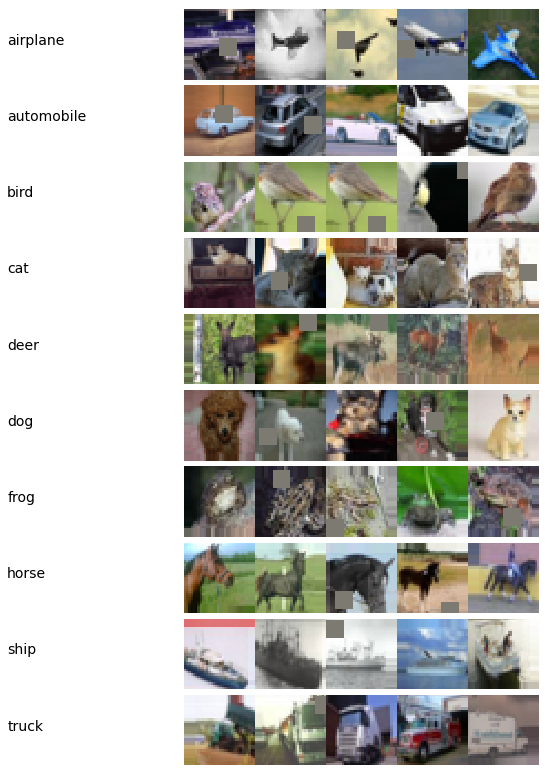

In [8]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow((unnormalize(images[idx[j-1]])*255).astype('uint8'), interpolation='none')
      plt.axis('off')
plt.show()

In [9]:
import eva4models1
import torch
model =eva4models1.newResnetS11()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

LR RANGE FINDER

In [10]:
import eva4LrRangeFinder
lrrange=eva4LrRangeFinder.lrRangeFinder(model,train_loader)
learning_rates,train_accuracy=lrrange.plot(epochs=10)

starting 1 epoch:



starting 2 epoch:



starting 3 epoch:



starting 4 epoch:



starting 5 epoch:



starting 6 epoch:



starting 7 epoch:



starting 8 epoch:



starting 9 epoch:



starting 10 epoch:


In [11]:
print(learning_rates)
print(train_accuracy)
max_lr=learning_rates[train_accuracy.index(max(train_accuracy))]

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
[0.026830279637896828, 0.027078018707482995, 0.027047847133645126, 0.027046739919926302, 0.02716770301870748, 0.026973663814484124, 0.026559842687074828, 0.026750560250141723, 0.027153309240362813, 0.026644544536564625]


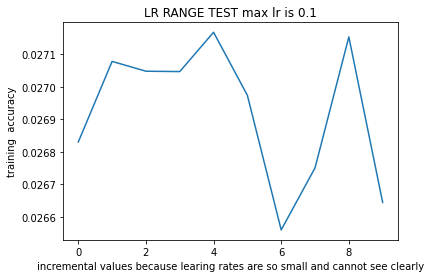

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_accuracy)
plt.title('LR RANGE TEST max lr is {}'.format(max_lr))
plt.ylabel('training  accuracy')
plt.xlabel('incremental values because learing rates are so small and cannot see clearly')
#plt.legend(['without L1 and L2', 'with L1','with L2','With L1 and L2'], loc='upper left')
plt.show()

Diagram of cyclic lr drawn using formulas

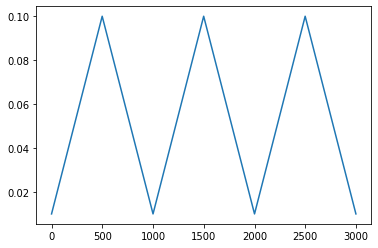

In [0]:
def annealing_factor(start,end,pct):
  return((end-start)*pct+start);

steps=1000
up=float(0.5*steps)-1
down=float(steps-up)-1
y=[annealing_factor(0.01,0.1,x/up) if(x<=up) else annealing_factor(0.1,0.01,(x-up)/down)for x in range(steps)]
y=y*3
x=list(range(len(y)))
plt.plot(x,y)
plt.show()

Training and Testing starts now

In [14]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 24
L2lambda = 0
batch_size=512
optimizer = optim.SGD(model.parameters(), lr=max_lr/10, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler =OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS,  pct_start=0.2, div_factor=10, final_div_factor=1 )
print("Initial LR- ",scheduler.get_lr())
print("Total steps - ", scheduler.total_steps)
print("No.of steps to increase LR -", scheduler.step_size_up)
print("No.of steps to reduce LR - ", scheduler.step_size_down)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "", scheduler, True, L1lambda)

Initial LR-  [0.009999999999999995]
Total steps -  2376
No.of steps to increase LR - 474.20000000000005
No.of steps to reduce LR -  1900.8



Validation loss decreased (100000.000000 --> 0.440084).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0002, Accuracy: 95.67%; Test set: Average loss: 0.4401, Accuracy: 87.47%
Learning Rate = 0.019156



Epoch: 2, Train set: Average loss: 0.0003, Accuracy: 94.51%; Test set: Average loss: 0.5053, Accuracy: 85.81%
Learning Rate = 0.042898



Epoch: 3, Train set: Average loss: 0.0004, Accuracy: 92.69%; Test set: Average loss: 0.4616, Accuracy: 86.40%
Learning Rate = 0.071564



Epoch: 4, Train set: Average loss: 0.0005, Accuracy: 91.42%; Test set: Average loss: 0.4543, Accuracy: 86.73%
Learning Rate = 0.093491



Epoch: 5, Train set: Average loss: 0.0005, Accuracy: 91.44%; Test set: Average loss: 0.6081, Accuracy: 82.69%
Learning Rate = 0.099985



Epoch: 6, Train set: Average loss: 0.0004, Accuracy: 92.39%; Test set: Average loss: 0.4654, Accuracy: 86.42%
Learning Rate = 0.099206



Epoch: 7, Train set: Average loss: 0.0004, Accuracy: 93.32%; Test set: Average loss: 0.5052, Accuracy: 85.36%
Learning Rate = 0.097271



Validation loss decreased (0.440084 --> 0.433468).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0003, Accuracy: 93.95%; Test set: Average loss: 0.4335, Accuracy: 87.54%
Learning Rate = 0.094229



Epoch: 9, Train set: Average loss: 0.0003, Accuracy: 94.46%; Test set: Average loss: 0.4602, Accuracy: 87.20%
Learning Rate = 0.090160



Epoch: 10, Train set: Average loss: 0.0003, Accuracy: 94.93%; Test set: Average loss: 0.4427, Accuracy: 88.28%
Learning Rate = 0.085171



Epoch: 11, Train set: Average loss: 0.0003, Accuracy: 95.40%; Test set: Average loss: 0.4653, Accuracy: 87.47%
Learning Rate = 0.079391



Validation loss decreased (0.433468 --> 0.416222).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0002, Accuracy: 95.83%; Test set: Average loss: 0.4162, Accuracy: 88.62%
Learning Rate = 0.072974



Validation loss decreased (0.416222 --> 0.405974).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0002, Accuracy: 96.19%; Test set: Average loss: 0.4060, Accuracy: 88.99%
Learning Rate = 0.066086



Epoch: 14, Train set: Average loss: 0.0002, Accuracy: 96.64%; Test set: Average loss: 0.4077, Accuracy: 89.09%
Learning Rate = 0.058907



Epoch: 15, Train set: Average loss: 0.0002, Accuracy: 97.08%; Test set: Average loss: 0.4734, Accuracy: 88.27%
Learning Rate = 0.051627



Epoch: 16, Train set: Average loss: 0.0002, Accuracy: 97.19%; Test set: Average loss: 0.4381, Accuracy: 88.84%
Learning Rate = 0.044434



Epoch: 17, Train set: Average loss: 0.0001, Accuracy: 97.33%; Test set: Average loss: 0.4305, Accuracy: 89.55%
Learning Rate = 0.037518



Epoch: 18, Train set: Average loss: 0.0001, Accuracy: 97.84%; Test set: Average loss: 0.4266, Accuracy: 89.56%
Learning Rate = 0.031060



Epoch: 19, Train set: Average loss: 0.0001, Accuracy: 98.21%; Test set: Average loss: 0.4226, Accuracy: 89.84%
Learning Rate = 0.025229



Epoch: 20, Train set: Average loss: 0.0001, Accuracy: 98.46%; Test set: Average loss: 0.4196, Accuracy: 90.00%
Learning Rate = 0.020177



Epoch: 21, Train set: Average loss: 0.0001, Accuracy: 98.55%; Test set: Average loss: 0.4302, Accuracy: 89.94%
Learning Rate = 0.016036



Epoch: 22, Train set: Average loss: 0.0001, Accuracy: 98.74%; Test set: Average loss: 0.4126, Accuracy: 90.54%
Learning Rate = 0.012916



Epoch: 23, Train set: Average loss: 0.0001, Accuracy: 98.92%; Test set: Average loss: 0.4127, Accuracy: 90.39%
Learning Rate = 0.010897



Epoch: 24, Train set: Average loss: 0.0001, Accuracy: 99.02%; Test set: Average loss: 0.4220, Accuracy: 90.39%
Learning Rate = 0.010033

